In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/train.csv
/kaggle/input/fake-news/test.csv


In [2]:
import re
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
random.seed(0)
np.random.seed(0)

In [4]:
df = pd.read_csv('../input/fake-news/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
df = df.dropna()

In [8]:
stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower() # lowering
    text = text.encode("ascii", "ignore").decode() # non ascii chars
    text = re.sub(r'\n',' ', text) # remove new-line characters
    text = re.sub(r'\W', ' ', text) # special chars
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) # single char at first
    text = re.sub(r'[0-9]', ' ', text) # digits
    text = re.sub(r'\s+', ' ', text, flags=re.I) # multiple spaces
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text) if word not in stop_words])

In [9]:
main = df[df['title'].notna()]

In [10]:
main

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [11]:
main.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

0    10361
1     7924
Name: label, dtype: int64


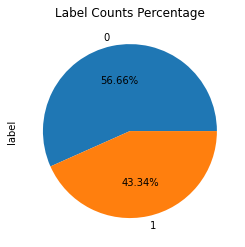

In [12]:
print(main['label'].value_counts())
main['label'].value_counts().plot(kind='pie', title='Label Counts Percentage', autopct='%1.2f%%')
plt.show()

In [13]:
main_title_author = (main['title'] + ' ' + main['author']).apply(clean_text)

In [14]:
main_title_author

0        hous dem aid didnt even see comey letter jason...
1        flynn hillari clinton big woman campu breitbar...
2                   truth might get fire consortiumnew com
3        civilian kill singl us airstrik identifi jessi...
4        iranian woman jail fiction unpublish stori wom...
                               ...                        
20795    rapper trump poster child white supremaci jero...
20796    n l playoff schedul matchup odd new york time ...
20797    maci said receiv takeov approach hudson bay ne...
20798    nato russia hold parallel exercis balkan alex ...
20799                              keep aliv david swanson
Length: 18285, dtype: object

In [17]:
x_train, x_test, y_train, y_test = train_test_split(main_title_author, main['label'])
len(x_train), len(x_test)

(13713, 4572)

In [18]:
tfidf_title_author = TfidfVectorizer()

train_x = tfidf_title_author.fit_transform(x_train)
test_x = tfidf_title_author.transform(x_test)

train_x, test_x

(<13713x14209 sparse matrix of type '<class 'numpy.float64'>'
 	with 147132 stored elements in Compressed Sparse Row format>,
 <4572x14209 sparse matrix of type '<class 'numpy.float64'>'
 	with 46523 stored elements in Compressed Sparse Row format>)

In [19]:
pac_title_author = PassiveAggressiveClassifier(class_weight='balanced').fit(train_x, y_train)

Accuracy : 0.9943132108486439
F1-Score : 0.99341104916371


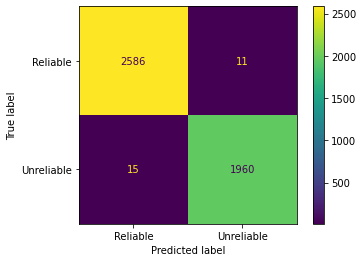

In [20]:
y_pred = pac_title_author.predict(test_x)

print(f"Accuracy : {accuracy_score(y_test, y_pred)}")
print(f"F1-Score : {f1_score(y_test, y_pred)}")

plot_confusion_matrix(pac_title_author, test_x, y_test, display_labels=['Reliable', 'Unreliable'])
plt.show()

In [21]:
whole_x = tfidf_title_author.transform(main_title_author)
whole_pred_y = pac_title_author.predict(whole_x)

print(f"Accuracy : {accuracy_score(main['label'], whole_pred_y)}")
print(f"F1-Score : {f1_score(main['label'], whole_pred_y)}")

Accuracy : 0.9985780694558382
F1-Score : 0.9983590002524616


In [22]:
main_text = df[df['text'].notna()]

main_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18285 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18285 non-null  int64 
 1   title   18285 non-null  object
 2   author  18285 non-null  object
 3   text    18285 non-null  object
 4   label   18285 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 857.1+ KB


0    10361
1     7924
Name: label, dtype: int64


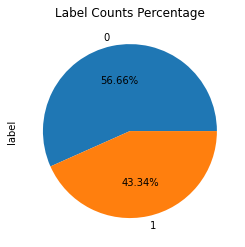

In [23]:
print(main_text['label'].value_counts())
main_text['label'].value_counts().plot(kind='pie', title='Label Counts Percentage', autopct='%1.2f%%')
plt.show()

In [24]:
main_clean_text = []

for text in tqdm(main_text['text']):
    main_clean_text.append(clean_text(text))

  0%|          | 0/18285 [00:00<?, ?it/s]

In [25]:
x_train, x_test, y_train, y_test = train_test_split(main_clean_text, main_text['label'])
len(x_train), len(x_test)

(13713, 4572)

In [26]:
tfidf_text = TfidfVectorizer()

train_x = tfidf_text.fit_transform(x_train)
test_x = tfidf_text.transform(x_test)

train_x, test_x

(<13713x96131 sparse matrix of type '<class 'numpy.float64'>'
 	with 3570659 stored elements in Compressed Sparse Row format>,
 <4572x96131 sparse matrix of type '<class 'numpy.float64'>'
 	with 1178121 stored elements in Compressed Sparse Row format>)

In [27]:
pac_text = PassiveAggressiveClassifier().fit(train_x, y_train)

Accuracy : 0.9566929133858267
F1-Score : 0.9495412844036698


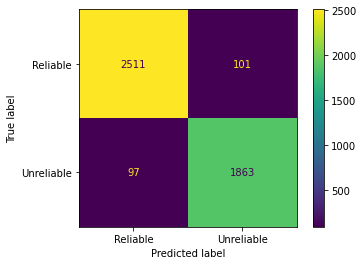

In [28]:
y_pred = pac_text.predict(test_x)

print(f"Accuracy : {accuracy_score(y_test, y_pred)}")
print(f"F1-Score : {f1_score(y_test, y_pred)}")

plot_confusion_matrix(pac_text, test_x, y_test, display_labels=['Reliable', 'Unreliable'])
plt.show()

In [29]:
whole_x = tfidf_text.transform(main_clean_text)
whole_pred_y = pac_text.predict(whole_x)

print(f"Accuracy : {accuracy_score(main_text['label'], whole_pred_y)}")
print(f"F1-Score : {f1_score(main_text['label'], whole_pred_y)}")

Accuracy : 0.9891167623735302
F1-Score : 0.9874471708824829


In [30]:
def get_predictions(df):
    preds = []

    for _, row in df.iterrows():
        if pd.isna(row['title']):
            x = tfidf_text.transform([clean_text(row['text'])])
            preds.append(pac_text.predict(x))
        else:
            data_title_author = row['title'] + ' ' + (row['author'] if pd.notna(row['author']) else 'unknown')
            x = tfidf_title_author.transform([clean_text(data_title_author)])
            preds.append(pac_title_author.predict(x))
    
    return np.array(preds).ravel()


In [31]:
preds = get_predictions(df)

print("Training set accuracy and f1-score")
print(f"Accuracy : {accuracy_score(df['label'], preds)}")
print(f"F1-Score : {f1_score(df['label'], preds)}")


Training set accuracy and f1-score
Accuracy : 0.9985780694558382
F1-Score : 0.9983590002524616


In [32]:
test_df = pd.read_csv("../input/fake-news/test.csv")
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [33]:
test_df.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [34]:
len(test_df[test_df['title'].isna() & test_df['text'].isna()])

0

In [35]:
test_preds = get_predictions(test_df)

In [36]:
submission = pd.DataFrame({'id' : test_df['id'], 'label' : test_preds})
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      5200 non-null   int64
 1   label   5200 non-null   int64
dtypes: int64(2)
memory usage: 81.4 KB


In [37]:
submission.to_csv('submission.csv', index=False)